# Sentiment Analysis with Hugging Face



Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [1]:
# Install the datasets library
!pip install datasets
!pip install sentencepiece
!pip install transformers datasets
!pip install transformers[torch]
!pip install accelerate
!pip install accelerate>=0.20.1
!pip install huggingface_hub
!pip install  -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import plotly
import string
import re
import matplotlib.pyplot as plt
from google.colab import files
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.model_selection import train_test_split

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AdamW
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import mean_squared_error
from huggingface_hub import notebook_login

In [3]:
notebook_login()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the dataset and display some values
df_train = pd.read_csv('/content/drive/MyDrive/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Test.csv')
# A way to eliminate rows containing NaN values
df_train = df_train[~df_train.isna().any(axis=1)]
df_test = df_test[~df_test.isna().any(axis=1)]

In [6]:
# Set the max_colwidth option to a higher value
pd.set_option('display.max_colwidth', None)

Because this project is basiscally for finetunning, we are not concentrating on  the EDA part however for the sake of the dataset, we need to check and understand it...
so, we will use the `CRISP-DM framework`


# Exploratory Data Analysis(EDA)

In [7]:
df_train.sample(4)

,tweet_id,safe_text,label,agreement
9103,8EYRM6A5,Denton County officials urge residents to get measles vaccine: More than 16 cases have been confirmed around... <url>,1.0,1.000000
987,65LY6B7B,"Yellow Fever vaccine #ghana (@ Passport Health NYC - <user> in New York, NY) <url>",0.0,1.000000
3285,ZK3S5U50,I have this theory. If you don't know anything about a vaccine except how to give it. I don't want to hear your constant rants about them.,1.0,0.666667
4090,QK8IMNIY,"<user> Amazing how somebody's ""firm"" belief that vaccinations are harmful, is changed when their kids get sick. Talk about ironic.",1.0,1.000000


In [8]:
df_test.sample(4)

,tweet_id,safe_text
3267,ML88C6DV,Vaccinate your kids <url>
179,16QKOG7D,“<user> Why isn't #cancer trending? They cured fucking cancer.” #measles
5094,ZEJM56CQ,"<user> reason you should vaccinate is that even if are vaccinated you can still be a carrier, which is risky"
4555,VG9E6DZ8,<user> vaccine injury destroyed my daughters life and my family. Pharma &amp; gov't plot to cover their ass through continued brainwashing


### Exploring Label and Agreement Column Balance

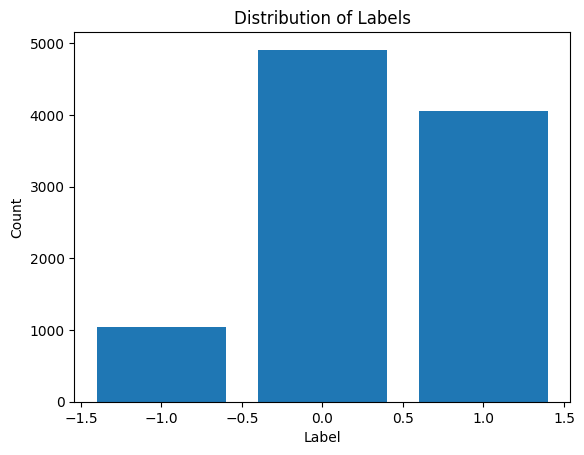

In [9]:
# Plot the distribution of labels
label_counts = df_train['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

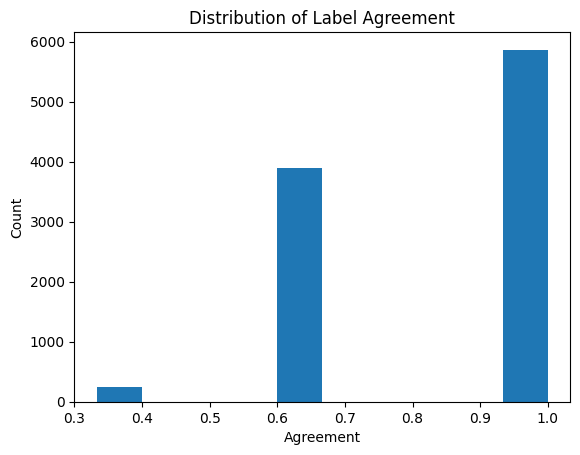

In [10]:
# Plot the distribution of 'agreement'
plt.hist(df_train['agreement'])
plt.xlabel('Agreement')
plt.ylabel('Count')
plt.title('Distribution of Label Agreement')
plt.show()

In [11]:
# Calculate the correlation between 'label' and 'agreement'
correlation = df_train['label'].corr(df_train['agreement'])

# Print the correlation value
print(f"Correlation: {correlation}")

Correlation: 0.13815479087588003


# EDA on safe text column

In [12]:
from collections import Counter

# Concatenate all the 'safe_text' into a single string
text = ' '.join(df_train['safe_text'])

# Split the text into words
words = text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Display the most common words
print(word_counts.most_common(10))

[('<url>', 4612), ('<user>', 4517), ('to', 3407), ('the', 3388), ('of', 2196), ('a', 2133), ('in', 1897), ('and', 1827), ('measles', 1747), ('I', 1604)]


# Data Cleaning

Issues:


*   Remove unneccesary columns.
*   Remove emojis and other characters from safe text column.
*   Remove punctuations from the safe tect column
*   Changing all text to lower cases.





In [13]:
# Remove unnecessary columns
df_train = df_train.drop(['tweet_id'], axis=1)
df_test = df_test.drop(['tweet_id'], axis=1)

In [14]:
# Clean the 'safe_text' column (example: remove URLs and special characters)
df_train['safe_text'] = df_train['safe_text'].str.replace(r'<url>', '')  # Remove <url> tag
df_test['safe_text'] = df_test['safe_text'].str.replace(r'<url>', '')  # Remove <url> tag

# Remove emojis and other special characters
emojis = re.compile(r'[^\w\s@#$%^*()<>/|}{~:]')
df_train["safe_text"] = df_train["safe_text"].str.replace(emojis, '')
df_test["safe_text"] = df_test["safe_text"].str.replace(emojis, '')

# # Remove punctuation
punctuation = string.punctuation
df_train["safe_text"] = df_train["safe_text"].str.translate(str.maketrans('', '', punctuation))
df_test["safe_text"] = df_test["safe_text"].str.translate(str.maketrans('', '', punctuation))

In [15]:
# Turn the safe_text column into lowercase
df_train["safe_text"] = df_train["safe_text"].str.lower()
df_test["safe_text"] = df_test["safe_text"].str.lower()

## Further EDA

In [16]:
from collections import Counter

# Concatenate all the 'safe_text' into a single string
text = ' '.join(df_train['safe_text'])

# Split the text into words
words = text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Display the most common words
print(word_counts.most_common(10))

[('user', 5494), ('the', 4118), ('to', 3636), ('measles', 3512), ('a', 2453), ('of', 2354), ('in', 2174), ('and', 1993), ('i', 1705), ('is', 1615)]


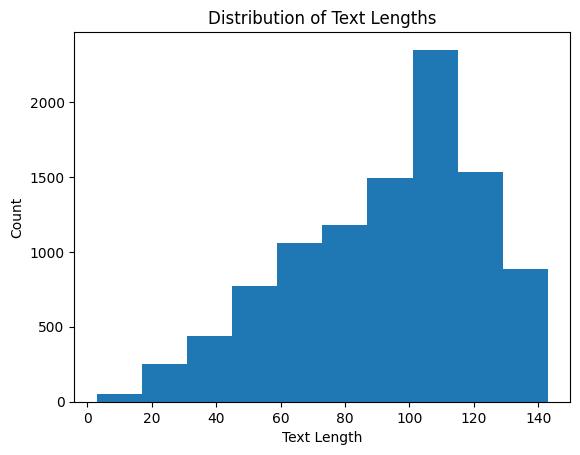

In [17]:
# Calculate the length of each text in 'safe_text'
text_lengths = df_train['safe_text'].apply(len)

# Plot the distribution of text lengths
plt.hist(text_lengths)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')
plt.show()

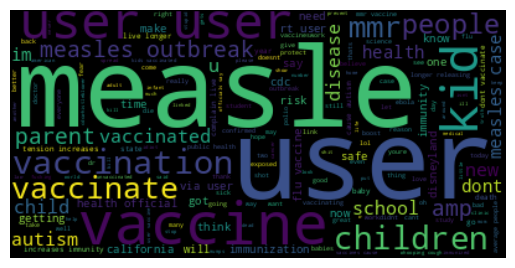

In [18]:
from wordcloud import WordCloud

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Further Cleaning

Removing Stop words

In [19]:
# Download the stop words (only required for the first time)
nltk.download('stopwords')

# Remove stop words
stop_words = set(stopwords.words('english'))
df_train['safe_text'] = df_train['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
df_test['safe_text'] = df_test['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [21]:
df_train.head()

,safe_text,label,agreement
0,amp big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,0.0,1.0
1,im 100 thinking devoting career proving autism isnt caused vaccines due idiotic posts ive seen world autism day,1.0,1.0
2,whatcausesautism vaccines vaccinate child,-1.0,1.0
3,mean immunize kid something wont secretly kill years line im dont trust,-1.0,1.0
4,thanks user catch performing la nuit nyc 1134 1st ave show starts 6 jennifair mmr,0.0,1.0


In [22]:
df_test.head()

,safe_text
0,user user amp 4 vaccine given 2 healthy peeps fda think worth ae risk unfortunately
1,students starting school without whooping cough vaccinations scpick
2,im kinda every ep user ripped headlines measles lets get back crime svu
3,many innocent children die lack vaccination year around 15 million bad parents couldnt sb277
4,cdc eyeing bird flu vaccine humans though risk low federal officials said wednesday theyre taking steps


# Export DataFrame as CSV

In [23]:
# Save df_train
df_train.to_csv('df_train.csv', index=False)

# Save df_test
df_test.to_csv('df_test.csv', index=False)

In [24]:
# # Download df_train.csv
# files.download('df_train.csv')

# # Download df_test.csv
# files.download('df_test.csv')

# Import Cleaned Data

In [25]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [26]:
# Load the dataset and display some values
df = pd.read_csv('/content/df_train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

# Train_Test_Split

In [27]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [28]:
train.head()

,safe_text,label,agreement
9303,mickeys measles gone international,0.0,1.000000
3907,s1256 new extends exemption charitable immunity certain civil actions persons age,0.0,1.000000
795,user ignorance vaccines isnt dangerous innocent child others around shame,1.0,0.666667
5791,pakistan partly suspends polio vaccination program terrorists kill health workers,0.0,1.000000
3431,news ive gone like 1000 mmr,0.0,1.000000


In [29]:
eval.head()

,safe_text,label,agreement
6569,childrens museum houston offer free vaccinations,1.0,1.000000
1754,user properly immunized prior performance kid puts legit show say,1.0,1.000000
3325,user thx posting vaccinations imperative dear puppy know died parvo terrible death humans wise,1.0,1.000000
1485,baby exactly everyone needs vaccinate via user,1.0,0.666667
4175,meeting tonight 830pm room 322 student center kent ksu kentstate immunizations childrenfirst,1.0,1.000000


In [30]:
# Print the shapes of the new dataframes
print(f"Shape of the train dataframe: {train.shape}")
print(f"Shape of the eval dataframe: {eval.shape}")

Shape of the train dataframe: (7999, 3)
Shape of the eval dataframe: (2000, 3)


### Saving Train and Eval Subset

In [31]:
import os
import pandas as pd

# Create the data directory
if not os.path.exists("../data"):
    os.makedirs("../data")

# Save splitted subsets
train.to_csv("../data/train_subset.csv", index=False)
eval.to_csv("../data/eval_subset.csv", index=False)

In [32]:
# Load the dataset from CSV files
dataset = load_dataset('csv',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data_files={'train': '../data/train_subset.csv',
                        'eval': '../data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-20baaab615d943a3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Transformers and Tokenization

In [33]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# "cardiffnlp/twitter-xlm-roberta-base-sentiment"
# "roberta-base"
# "xlnet-base-cased"
# "bert-base-uncased"

# Import the tokenizer from transformers library
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [34]:
# Function to transform labels
def transform_labels(label):
    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

# Function to tokenize data
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [36]:
from transformers import TrainingArguments
import transformers

# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Training Arguments
training_args = TrainingArguments(
    output_dir="mytuned_test_trainer-cardiffnlp/bert-base-uncased",
    num_train_epochs=10,
    load_best_model_at_end=True,
    save_strategy="epoch",
    push_to_hub=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Loading Pre-Trained Model

In [37]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Splitting Train Set

In [38]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

### Evaluation Metric

In [39]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"rmse": mean_squared_error(labels, predictions, squared=False)}

## Model Training Setup

In [40]:
# Model Training Setup
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)


Cloning https://huggingface.co/MrDdz/bert-base-uncased into local empty directory.


In [41]:
# Launch the learning process: training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse
1,0.718200,0.638664,0.676757
2,0.566200,0.644373,0.675278
3,0.390100,0.679987,0.689202


KeyboardInterrupt: ignored

In [42]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer.evaluate()

<ipython-input-42-cd8ec6884614>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Epoch,Training Loss,Validation Loss,Rmse
1,0.718200,0.638664,0.676757
2,0.566200,0.644373,0.675278
3,0.390100,0.679987,0.689202
3,0.390100,0.679987,0.689202


{'eval_loss': 0.6799871921539307, 'eval_rmse': 0.689202437604511}

In [43]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Jul22_20-32-54_c12d56bc3b31/events.out.tfevents.1690057996.c12d56bc3b31.1078.0:   0%|        …

To https://huggingface.co/MrDdz/bert-base-uncased
   bf5a78a..e7d10ad  main -> main

   bf5a78a..e7d10ad  main -> main

To https://huggingface.co/MrDdz/bert-base-uncased
   e7d10ad..f9076d5  main -> main

   e7d10ad..f9076d5  main -> main



'https://huggingface.co/MrDdz/bert-base-uncased/commit/e7d10ad9a8644285d243c0f7153f9f82cfc2f3fe'